In [1]:
import tensorflow as tf
import keras
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, Activation
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from datetime import datetime
#import warnings
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

Using TensorFlow backend.


In [2]:
def parser(x):
    return datetime.strptime(x, '%d-%b-%Y')

In [3]:
def get_data(path, date):
    data = pd.read_csv(path , header=0, parse_dates=[date], index_col=date, squeeze=True, date_parser=parser)
    return data

In [4]:
class LSTM_RNN:

    def __init__(self, look_back, batch_size, ip_size, dropout_probability = 0.2, init ='he_uniform', loss='mse', optimizer='adam'):
        
        self.batch_size = batch_size
        self.look_back = look_back
        self.rnn = Sequential()
        self.rnn.add(LSTM(units=256,input_shape=(None, ip_size), init=init, return_sequences=True))
        
        self.rnn.add(Dropout(dropout_probability))
        self.rnn.add(Dense(1))
        self.rnn.add(Activation("linear"))
        #         self.rnn.add(Flatten())
        self.rnn.add(Dense(1, init=init))
        self.rnn.compile(loss=loss, optimizer=optimizer)
        print(self.rnn.summary())

    def train(self, X, Y, nb_epoch=150):
        self.rnn.fit(X, Y, nb_epoch=nb_epoch, batch_size=self.batch_size, verbose=2)

    def evaluate(self, X, Y):
        score = self.rnn.evaluate(X, Y, batch_size = self.batch_size, verbose=0)
        print(score)
        return score

    def predict(self, X):
        return self.rnn.predict(X)

In [5]:
def evaluate_models(look_back, batch_size, trainX, trainY, testX, testY, ret=False):
    print('Training & evaluating LSTM-RNN for batch size = ' + str(batch_size) + '...')
    (_, _, j) = trainX.shape
    if j > look_back:
        lstm_model = LSTM_RNN(look_back, batch_size, ip_size=j)
    else:
        lstm_model = LSTM_RNN(look_back, batch_size, ip_size=look_back)
    lstm_model.train(trainX, trainY)
    lstm_test_mse = lstm_model.evaluate(testX, testY)
    print("With batch size = " + str(batch_size) + ", Score: " + str(lstm_test_mse))
    print('Completed model evaluation for batch size = ' + str(batch_size) + '...')
    if ret:
        yhat = lstm_model.predict(testX)
        return lstm_test_mse, yhat
    del lstm_model
    return lstm_test_mse

In [6]:
def print_results(lstm_mse_vals):
    print('Completed model evaluation for all lookback values...')
    lstm_mse_min = min(lstm_mse_vals)
    lstm_mse_argmin = np.argmin(lstm_mse_vals) + 1
    print('Best mse with an LSTM recurrent neural network was ' + str(lstm_mse_min) + ' with a batch size of ' + str(lstm_mse_argmin))
    return lstm_mse_argmin

In [ ]:
#  #Ran this on kaggle to get an optimum value of 43
# mse_vals = []
# for batch_size in range(1, 51):
#     np.random.seed(10)
#     mse_vals.append(evaluate_models(look_back, batch_size, x, y, act, act_y))
# min_bs = print_results(mse_vals)
    
# np.random.seed(10)
# mse_val, y_hat = evaluate_models(look_back, min_bs, x, y, act, act_y, True)

Training & evaluating LSTM-RNN for batch size = 43...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 5), return_sequences=True, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 256)         268288    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           257       
_________________________________________________________________
activation_1 (Activation)    (None, None, 1)           0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           2         
Total params: 268,547
Trainable params: 268,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 6s - loss: 0.4964
Epoch 2/150
 - 1s - loss: 1.0362
Epoch 3/150
 - 1s - loss: 0.2969
Epoch 4/150
 - 1s - loss: 0.4037

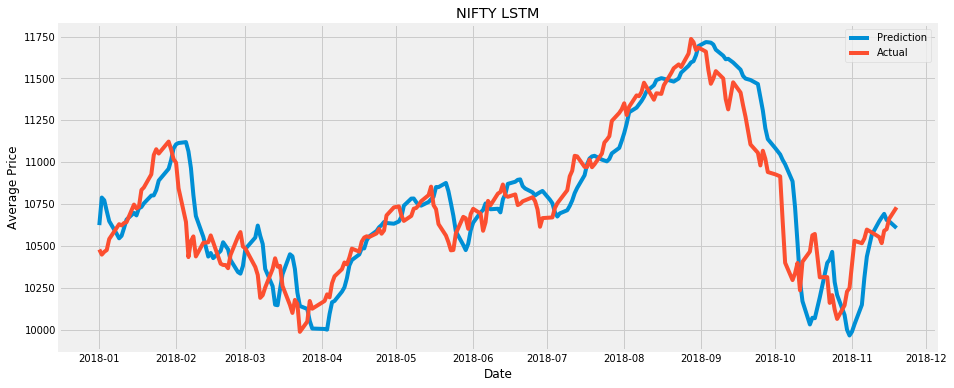

RMSE: 189.35024928093634
MAPE: 1.362965300338482


In [7]:
np.random.seed(10)
title = 'NIFTY LSTM'
look_back = 5
x = get_data('../ml-project-data/NIFTY_train.csv', 0)
y = x.loc[: , "High":"Low"].mean(axis=1)
data_y = y       
x_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    x_lag['t-'+str(i)] = y.shift(i)
x = x_lag

x = x.iloc[look_back:]
y = y.iloc[look_back:]

act_data = get_data('../ml-project-data/NIFTY_test.csv', 0)
act = act_data.loc[: , "High":"Low"].mean(axis=1)
idx = act_data.index
act_y = act
act = pd.concat([y[-5:], act])

act_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    act_lag['t-'+str(i)] = act.shift(i)

act = act_lag[look_back:]

scaler = MinMaxScaler()
x = scaler.fit_transform(x.values)
y = scaler.fit_transform(y.values.reshape(-1, 1))
act = scaler.fit_transform(act.values)
act_y = scaler.fit_transform(act_y.values.reshape(-1, 1))

i, j = x.shape
x = x.reshape(1, i , j)
y = y.reshape(1, len(y), 1)
i,j = act.shape
act = act.reshape(1, i , j)
act_y = act_y.reshape(1, len(act_y), 1)


min_bs = 43
np.random.seed(10)
mse_val, y_hat = evaluate_models(look_back, min_bs, x, y, act, act_y, True)

y_hat = y_hat.reshape(len(y_hat[0]))
act = act_y.reshape(len(act_y[0]))

preds = pd.DataFrame(y_hat,columns=['Prediction'],index=idx)
actuals = pd.DataFrame(act,columns=['Actual'],index=idx)

preds = scaler.inverse_transform(preds)
actuals = scaler.inverse_transform(actuals)

plt.figure(figsize=(14,6))
plt.plot(idx, preds, label="Prediction")
plt.plot(idx, actuals, label="Actual")
plt.ylabel("Average Price")
plt.xlabel('Date')
plt.title(title)
plt.legend(loc="best")
plt.show()


rms = sqrt(mean_squared_error(actuals, preds))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
print('MAPE: ' + str(mape))

In [8]:
def company_without_nifty(company):
    np.random.seed(10)
    if(company == 1):
        title = 'TCS LSTM w/o NIFTY'
        tcs_x = get_data('../ml-project-data/TCS_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/TCS_test.csv', 2)['Average Price']
    
    if(company == 2):
        title = 'INFY LSTM w/o NIFTY'
        tcs_x = get_data('../ml-project-data/INFY_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/INFY_test.csv', 2)['Average Price']
        
    if(company == 3):
        title = 'TECHM LSTM w/o NIFTY'
        tcs_x = get_data('../ml-project-data/TECHM_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/TECHM_test.csv', 2)['Average Price']
    
    if(company == 4):
        title = 'HCL LSTM w/o NIFTY'
        tcs_x = get_data('../ml-project-data/HCL_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/HCL_test.csv', 2)['Average Price']
        
    if(company == 5):
        title = 'WIPRO LSTM w/o NIFTY'
        tcs_x = get_data('../ml-project-data/WIPRO_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/WIPRO_test.csv', 2)['Average Price']
        
    look_back = 5
    
    tcs_y = tcs_x

    tcs_x_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_x_lag['t-'+str(i)] = tcs_y.shift(i)
    tcs_x = tcs_x_lag

    tcs_x = tcs_x.iloc[look_back:]
    tcs_y = tcs_y.iloc[look_back:]

    

    tcs_idx = tcs_act.index

    tcs_act_y = tcs_act
    tcs_act = pd.concat([tcs_y[-5:], tcs_act])

    tcs_act_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_act_lag['t-'+str(i)] = tcs_act.shift(i)

    tcs_act = tcs_act_lag[look_back:]

    scaler = MinMaxScaler()
    tcs_x = scaler.fit_transform(tcs_x.values)
    tcs_y = scaler.fit_transform(tcs_y.values.reshape(-1, 1))
    tcs_act = scaler.fit_transform(tcs_act.values)
    tcs_act_y = scaler.fit_transform(tcs_act_y.values.reshape(-1, 1))

    i, j = tcs_x.shape
    tcs_x = tcs_x.reshape(1, i , j)
    tcs_y = tcs_y.reshape(1, len(tcs_y), 1)
    i,j = tcs_act.shape
    tcs_act = tcs_act.reshape(1, i , j)
    tcs_act_y = tcs_act_y.reshape(1, len(tcs_act_y), 1)


    np.random.seed(10)
    min_bs = 1
    tcs_mse_val, tcs_y_hat = evaluate_models(look_back, min_bs, tcs_x, tcs_y, tcs_act, tcs_act_y, True)


    tcs_y_hat = tcs_y_hat.reshape(len(tcs_y_hat[0]))
    tcs_act = tcs_act_y.reshape(len(tcs_act_y[0]))

    tcs_preds = pd.DataFrame(tcs_y_hat,columns=['Prediction'],index=tcs_idx)
    tcs_actuals = pd.DataFrame(tcs_act,columns=['Actual'],index=tcs_idx)

    tcs_preds = scaler.inverse_transform(tcs_preds)
    tcs_actuals = scaler.inverse_transform(tcs_actuals)

    plt.figure(figsize=(14,6))
    plt.plot(tcs_idx, tcs_preds, label="Prediction")
    plt.plot(tcs_idx, tcs_actuals, label="Actual")
    plt.ylabel("Average Price")
    plt.xlabel('Date')
    plt.title(title)
    plt.legend(loc="best")
    plt.show()


    rms = sqrt(mean_squared_error(tcs_actuals, tcs_preds))
    print('RMSE: ' + str(rms))

    mape = np.mean(np.abs((tcs_actuals - tcs_preds) / tcs_actuals)) * 100
    print('MAPE: ' + str(mape))

In [ ]:
# mse_vals = []
# for batch_size in range(1, 51):
#     np.random.seed(10)
#     mse_vals.append(evaluate_models(look_back, batch_size, tcs_x, tcs_y, tcs_act, tcs_act_y))
# min_bs = print_results(mse_vals)

Training & evaluating LSTM-RNN for batch size = 1...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 5), return_sequences=True, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 256)         268288    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           257       
_________________________________________________________________
activation_3 (Activation)    (None, None, 1)           0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           2         
Total params: 268,547
Trainable params: 268,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 3s - loss: 0.7344
Epoch 2/150
 - 1s - loss: 0.7762
Epoch 3/150
 - 1s - loss: 0.5768
Epoch 4/150
 - 1s - loss: 0.2435

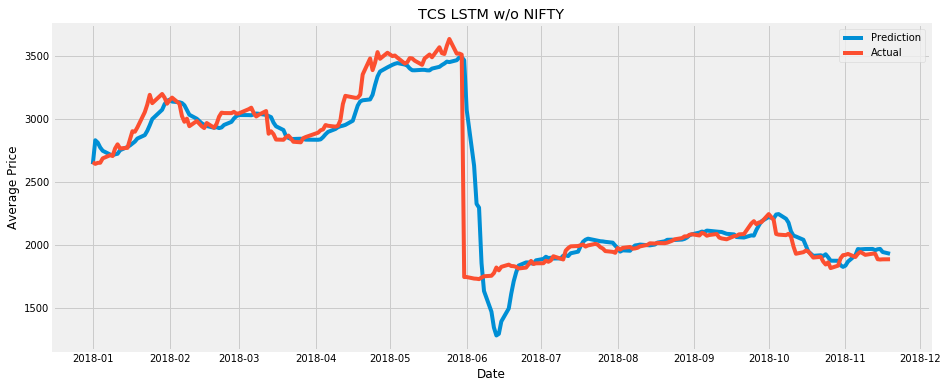

RMSE: 200.18207572026213
MAPE: 4.224200539050362


In [14]:
company_without_nifty(1) #TCS

Training & evaluating LSTM-RNN for batch size = 1...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 5), return_sequences=True, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 256)         268288    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           257       
_________________________________________________________________
activation_4 (Activation)    (None, None, 1)           0         
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           2         
Total params: 268,547
Trainable params: 268,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 3s - loss: 0.3190
Epoch 2/150
 - 1s - loss: 0.6106
Epoch 3/150
 - 1s - loss: 0.1742
Epoch 4/150
 - 1s - loss: 0.2854

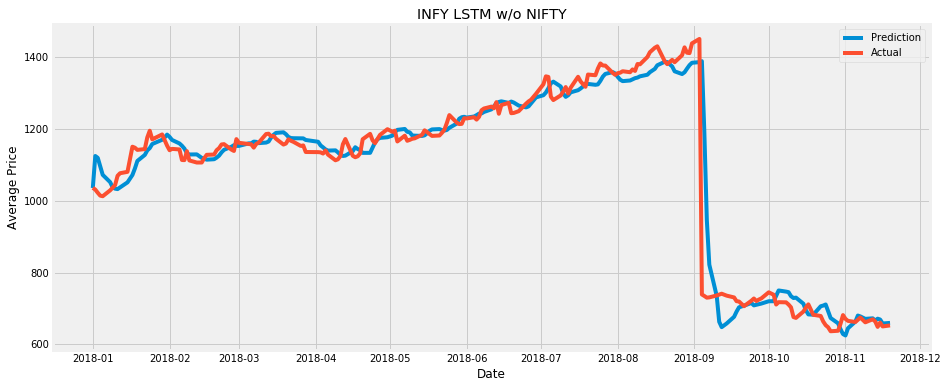

RMSE: 63.68811883163279
MAPE: 3.122195702938981


In [15]:
company_without_nifty(2) #INFY

Training & evaluating LSTM-RNN for batch size = 1...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 5), return_sequences=True, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 256)         268288    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           257       
_________________________________________________________________
activation_2 (Activation)    (None, None, 1)           0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           2         
Total params: 268,547
Trainable params: 268,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 2s - loss: 0.2689
Epoch 2/150
 - 1s - loss: 0.4451
Epoch 3/150
 - 1s - loss: 0.1317
Epoch 4/150
 - 1s - loss: 0.3099

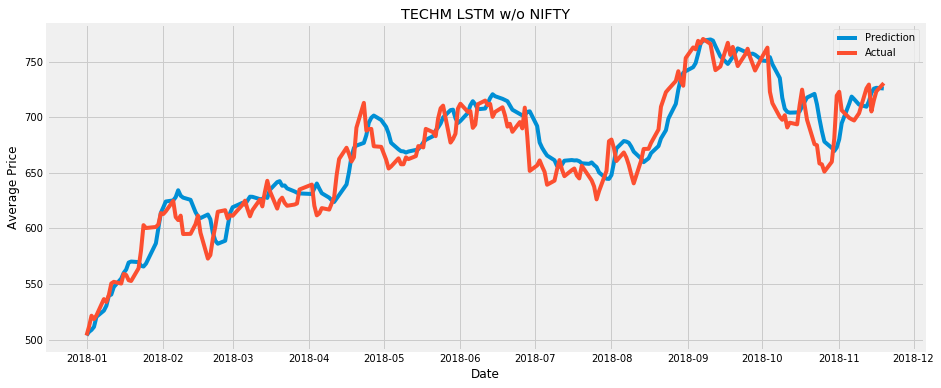

RMSE: 17.921052036645733
MAPE: 2.181580089802378


In [9]:
company_without_nifty(3) #TECHM

Training & evaluating LSTM-RNN for batch size = 1...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 5), return_sequences=True, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 256)         268288    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_11 (Dense)             (None, None, 1)           257       
_________________________________________________________________
activation_6 (Activation)    (None, None, 1)           0         
_________________________________________________________________
dense_12 (Dense)             (None, None, 1)           2         
Total params: 268,547
Trainable params: 268,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 3s - loss: 0.2499
Epoch 2/150
 - 1s - loss: 0.2294
Epoch 3/150
 - 1s - loss: 0.5271
Epoch 4/150
 - 1s - loss: 0.2096

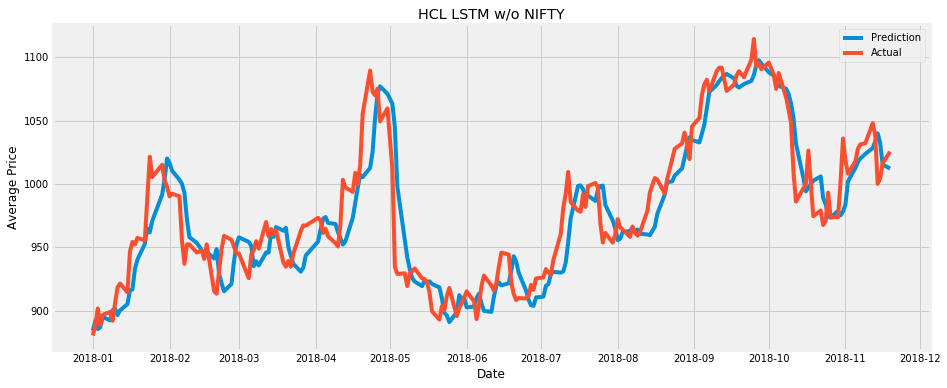

RMSE: 23.571958318134538
MAPE: 1.7867616855348731


In [17]:
company_without_nifty(4) #HCL

Training & evaluating LSTM-RNN for batch size = 1...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 5), return_sequences=True, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 256)         268288    
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_13 (Dense)             (None, None, 1)           257       
_________________________________________________________________
activation_7 (Activation)    (None, None, 1)           0         
_________________________________________________________________
dense_14 (Dense)             (None, None, 1)           2         
Total params: 268,547
Trainable params: 268,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 3s - loss: 0.5690
Epoch 2/150
 - 1s - loss: 1.0264
Epoch 3/150
 - 1s - loss: 0.4205
Epoch 4/150
 - 1s - loss: 0.2947

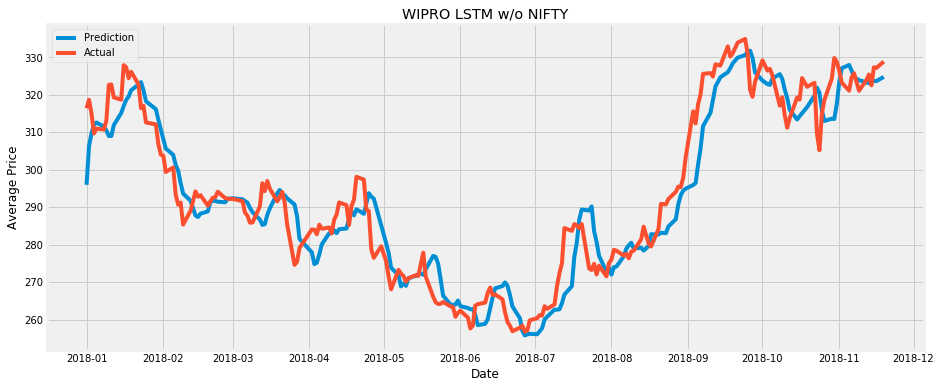

RMSE: 6.910655929197406
MAPE: 1.8365334578121748


In [18]:
company_without_nifty(5) #WIPRO

In [10]:
def company_with_nifty(company):
    np.random.seed(10)
    
    if(company == 1):
        title = 'TCS LSTM w NIFTY'
        tcs_x = get_data('../ml-project-data/TCS_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/TCS_test.csv', 2)['Average Price']
    
    if(company == 2):
        title = 'INFY LSTM w NIFTY'
        tcs_x = get_data('../ml-project-data/INFY_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/INFY_test.csv', 2)['Average Price']
        
    if(company == 3):
        title = 'TECHM LSTM w NIFTY'
        tcs_x = get_data('../ml-project-data/TECHM_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/TECHM_test.csv', 2)['Average Price']
    
    if(company == 4):
        title = 'HCL LSTM w NIFTY'
        tcs_x = get_data('../ml-project-data/HCL_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/HCL_test.csv', 2)['Average Price']
        
    if(company == 5):
        title = 'WIPRO LSTM w NIFTY'
        tcs_x = get_data('../ml-project-data/WIPRO_train.csv', 2)['Average Price']
        tcs_act = get_data('../ml-project-data/WIPRO_test.csv', 2)['Average Price']
        
    look_back = 5
    
    tcs_y = tcs_x

    tcs_x_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_x_lag['t-'+str(i)] = tcs_y.shift(i)
    tcs_x = tcs_x_lag

    tcs_x = tcs_x.iloc[look_back:]
    tcs_y = tcs_y.iloc[look_back:]


    tcs_idx = tcs_act.index

    tcs_act_y = tcs_act
    tcs_act = pd.concat([tcs_y[-5:], tcs_act])

    tcs_act_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_act_lag['t-'+str(i)] = tcs_act.shift(i)

    tcs_act = tcs_act_lag[look_back:]
    
    
    tcs_x['nifty'] = data_y
    tcs_act['nifty'] = preds

    scaler = MinMaxScaler()
    tcs_x = scaler.fit_transform(tcs_x.values)
    tcs_y = scaler.fit_transform(tcs_y.values.reshape(-1, 1))
    tcs_act = scaler.fit_transform(tcs_act.values)
    tcs_act_y = scaler.fit_transform(tcs_act_y.values.reshape(-1, 1))

    i, j = tcs_x.shape
    tcs_x = tcs_x.reshape(1, i , j)
    tcs_y = tcs_y.reshape(1, len(tcs_y), 1)
    i,j = tcs_act.shape
    tcs_act = tcs_act.reshape(1, i , j)
    tcs_act_y = tcs_act_y.reshape(1, len(tcs_act_y), 1)


    np.random.seed(10)
    min_bs = 49
    tcs_mse_val, tcs_y_hat = evaluate_models(look_back, min_bs, tcs_x, tcs_y, tcs_act, tcs_act_y, True)

    tcs_y_hat = tcs_y_hat.reshape(len(tcs_y_hat[0]))
    tcs_act = tcs_act_y.reshape(len(tcs_act_y[0]))

    tcs_preds = pd.DataFrame(tcs_y_hat,columns=['Prediction'],index=tcs_idx)
    tcs_actuals = pd.DataFrame(tcs_act,columns=['Actual'],index=tcs_idx)

    tcs_preds = scaler.inverse_transform(tcs_preds)
    tcs_actuals = scaler.inverse_transform(tcs_actuals)

    plt.figure(figsize=(14,6))
    plt.plot(tcs_idx, tcs_preds, label="Prediction")
    plt.plot(tcs_idx, tcs_actuals, label="Actual")
    plt.ylabel("Average Value")
    plt.xlabel('Date')
    plt.title(title)
    plt.legend(loc="best")
    plt.show()


    rms = sqrt(mean_squared_error(tcs_actuals, tcs_preds))
    print('RMSE: ' + str(rms))

    mape = np.mean(np.abs((tcs_actuals - tcs_preds) / tcs_actuals)) * 100
    print('MAPE: ' + str(mape))

In [ ]:
# mse_vals = []
# for batch_size in range(1, 51):
#     np.random.seed(10)
#     mse_vals.append(evaluate_models(look_back, batch_size, tcs_x, tcs_y, tcs_act, tcs_act_y))
# min_bs = print_results(mse_vals)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 6), return_sequences=True, kernel_initializer="he_uniform")`
  


Training & evaluating LSTM-RNN for batch size = 49...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, None, 256)         269312    
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_17 (Dense)             (None, None, 1)           257       
_________________________________________________________________
activation_9 (Activation)    (None, None, 1)           0         
_________________________________________________________________
dense_18 (Dense)             (None, None, 1)           2         
Total params: 269,571
Trainable params: 269,571
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 3s - loss: 1.0679
Epoch 2/150
 - 1s - loss: 0.6369
Epoch 3/150
 - 1s - loss: 0.7745
Epoch 4/150
 - 1s - loss: 0.3045

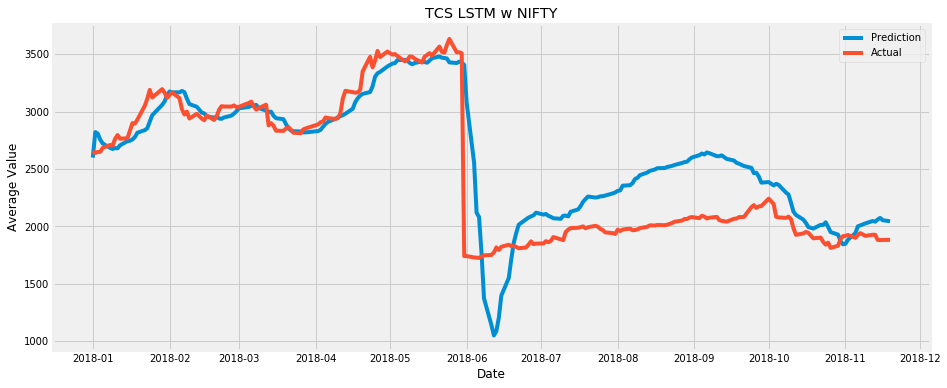

RMSE: 300.2988351463691
MAPE: 10.030874490620329


In [22]:
company_with_nifty(1) #TCS

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 6), return_sequences=True, kernel_initializer="he_uniform")`
  


Training & evaluating LSTM-RNN for batch size = 49...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 256)         269312    
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
dense_19 (Dense)             (None, None, 1)           257       
_________________________________________________________________
activation_10 (Activation)   (None, None, 1)           0         
_________________________________________________________________
dense_20 (Dense)             (None, None, 1)           2         
Total params: 269,571
Trainable params: 269,571
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 3s - loss: 0.7960
Epoch 2/150
 - 1s - loss: 0.2937
Epoch 3/150
 - 2s - loss: 0.6229
Epoch 4/150
 - 2s - loss: 0.3455

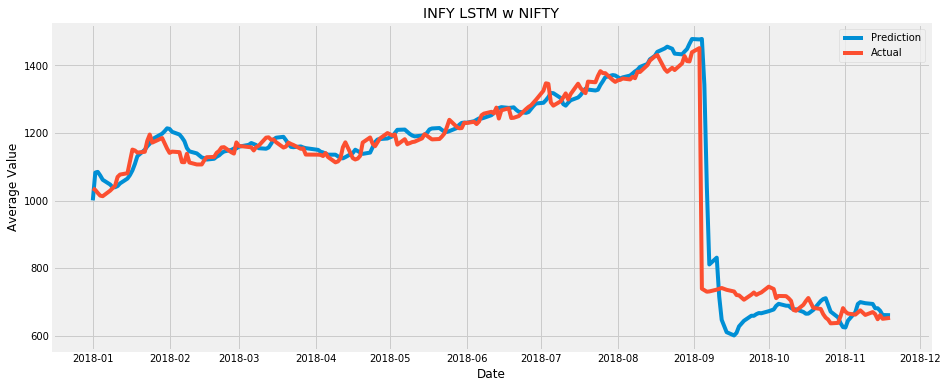

RMSE: 76.46804634955403
MAPE: 3.7166491663927603


In [23]:
company_with_nifty(2) #INFY

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 6), return_sequences=True, kernel_initializer="he_uniform")`
  


Training & evaluating LSTM-RNN for batch size = 49...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 256)         269312    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           257       
_________________________________________________________________
activation_3 (Activation)    (None, None, 1)           0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           2         
Total params: 269,571
Trainable params: 269,571
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 3s - loss: 0.7607
Epoch 2/150
 - 1s - loss: 0.3259
Epoch 3/150
 - 1s - loss: 0.5742
Epoch 4/150
 - 1s - loss: 0.3059

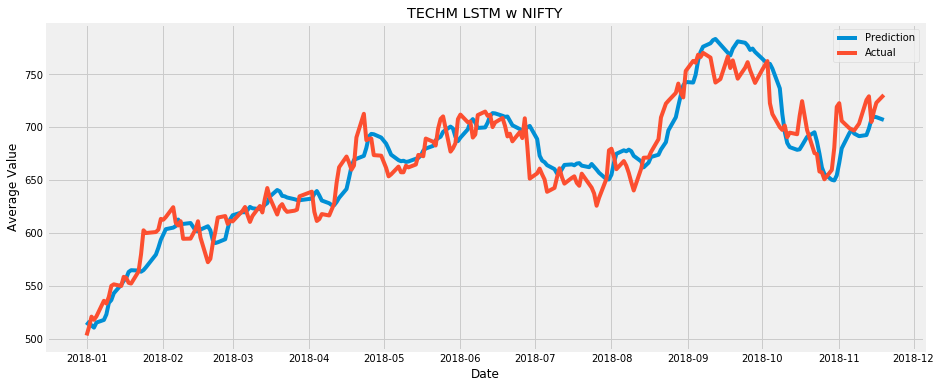

RMSE: 18.371912590164854
MAPE: 2.182116759368078


In [11]:
company_with_nifty(3) #TECHM

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 6), return_sequences=True, kernel_initializer="he_uniform")`
  


Training & evaluating LSTM-RNN for batch size = 49...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, None, 256)         269312    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
dense_23 (Dense)             (None, None, 1)           257       
_________________________________________________________________
activation_12 (Activation)   (None, None, 1)           0         
_________________________________________________________________
dense_24 (Dense)             (None, None, 1)           2         
Total params: 269,571
Trainable params: 269,571
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 3s - loss: 0.5727
Epoch 2/150
 - 1s - loss: 0.3532
Epoch 3/150
 - 1s - loss: 0.4655
Epoch 4/150
 - 1s - loss: 0.3267

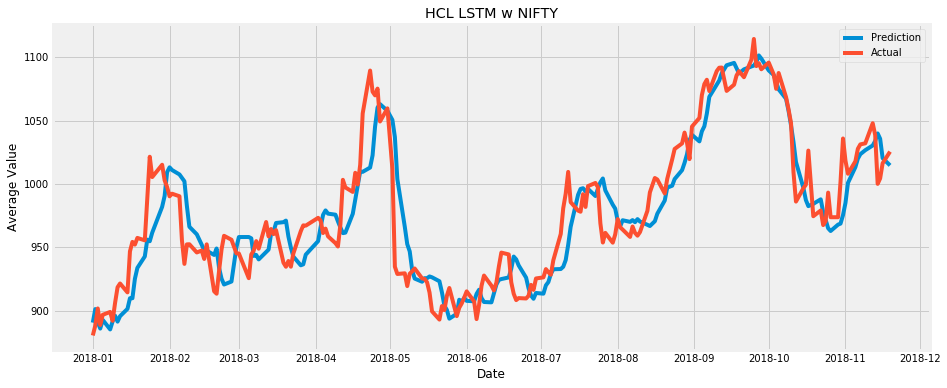

RMSE: 23.94276702370191
MAPE: 1.8279734591294297


In [35]:
company_with_nifty(4) #HCL

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training & evaluating LSTM-RNN for batch size = 49...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, input_shape=(None, 6), return_sequences=True, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, None, 256)         269312    
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
dense_25 (Dense)             (None, None, 1)           257       
_________________________________________________________________
activation_13 (Activation)   (None, None, 1)           0         
_________________________________________________________________
dense_26 (Dense)             (None, None, 1)           2         
Total params: 269,571
Trainable params: 269,571
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
 - 4s - loss: 0.8716
Epoch 2/150
 - 1s - loss: 0.7913
Epoch 3/150
 - 1s - loss: 0.5575
Epoch 4/150
 - 1s - loss: 0.2916

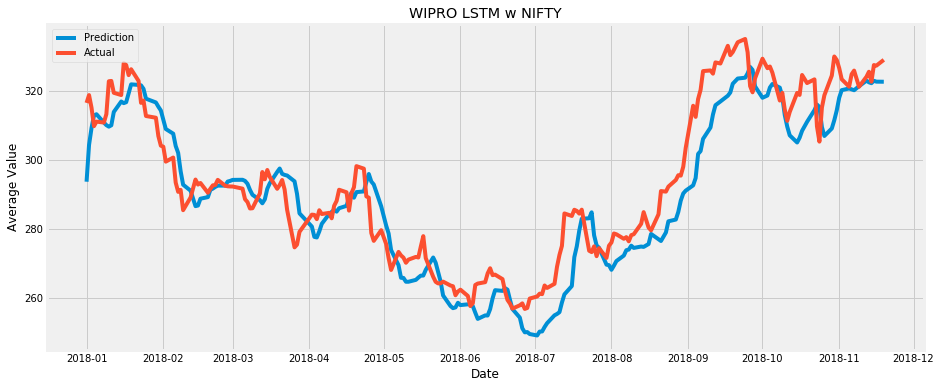

RMSE: 8.597425201561196
MAPE: 2.3854286757055037


In [36]:
company_with_nifty(5) #WIPRO